<a href="https://colab.research.google.com/github/rameshnatarajanus/dynamax/blob/modifications-to-kf_linreg/docs/notebooks/linear_gaussian_ssm/kf_linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online linear regression using Kalman filtering

We perform sequential (recursive) Bayesian inference for the parameters of a linear regression model
using the Kalman filter. (This algorithm is also known as recursive least squares.)
To do this, we treat the parameers of the model as the unknown hidden states.
We assume that these are constant over time.
The graphical model is shown below.

![RLS](https://github.com/probml/dynamax/blob/main/docs/figures/rlsDgm.png?raw=true)

The model has the following form

\begin{align*}
\theta_t &=  \theta_{t-1}  \\
y_t &= x_t^T \theta_t + r_t, \; r_t \sim N(0, \sigma^2)
\end{align*}

This is a LG-SSM, where $F=I$, $Q=0$, $H_t = x_t^T$ and $R = \sigma^2$.


## Setup

In [3]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install dynamax[notebooks]
    import dynamax

In [4]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

## Data

Data is from https://github.com/probml/pmtk3/blob/master/demos/linregOnlineDemoKalman.m


Text(0.5, 1.0, 'Observations')

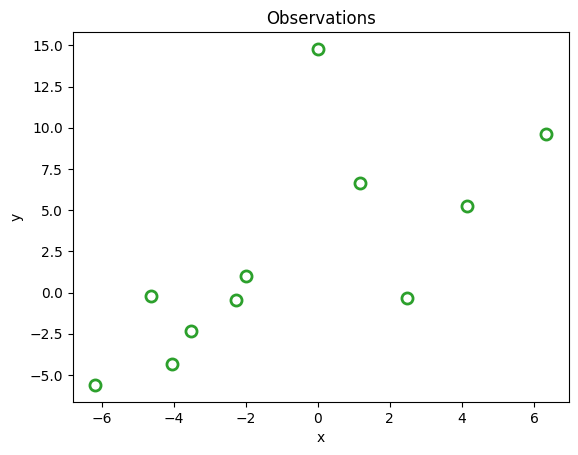

In [8]:
n_obs = 21
x = jnp.linspace(0, 20, n_obs)
X = jnp.column_stack((jnp.ones_like(x), x))  # Design matrix.
y = jnp.array(
    [2.486, -0.303, -4.053, -4.336, -6.174, -5.604, -3.507, -2.326, -4.638, -0.233, -1.986, 1.028, -2.264,
     -0.451, 1.167, 6.652, 4.145, 5.268, 6.34, 9.626, 14.784])

# plot data

# Plot Data
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig1, ax1 = plt.subplots()
ax1.plot(*y, ls="", **observation_marker_kwargs, color="tab:green", label="observations")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Observations")

## Model

In [12]:
F = jnp.eye(2)
Q = jnp.zeros((2, 2))  # No parameter drift.
obs_var = 1.0
R = jnp.ones((1, 1)) * obs_var
prior_mean = jnp.zeros(2)
prior_cov = jnp.eye(2) * 10.0


# the input_dim = 0 since we encode the covariates into the non-stationary emission matrix
lgssm = LinearGaussianSSM(state_dim = 2, emission_dim = 1, input_dim = 0)
params, _ = lgssm.initialize(
    initial_mean=prior_mean,
    initial_covariance=prior_cov,
    dynamics_weights=F,
    dynamics_covariance=Q,
    emission_weights=X[:, None, :], # (t, 1, D) where D = num input features
    emission_covariance=R,
    )

## Online inference

In [13]:
lgssm_posterior = lgssm.filter(params, y[:, None]) # reshape y to be (T,1)
kf_results = (lgssm_posterior.filtered_means, lgssm_posterior.filtered_covariances)

## Offline inferenece

We compute the offline posterior given all the data using Bayes rule for linear regression.
This should give the same results as the final step of online inference.

In [14]:
posterior_prec = jnp.linalg.inv(prior_cov) + X.T @ X / obs_var
b = jnp.linalg.inv(prior_cov) @ prior_mean + X.T @ y / obs_var
posterior_mean = jnp.linalg.solve(posterior_prec, b)
batch_results = (posterior_mean, posterior_prec)


## Plot results

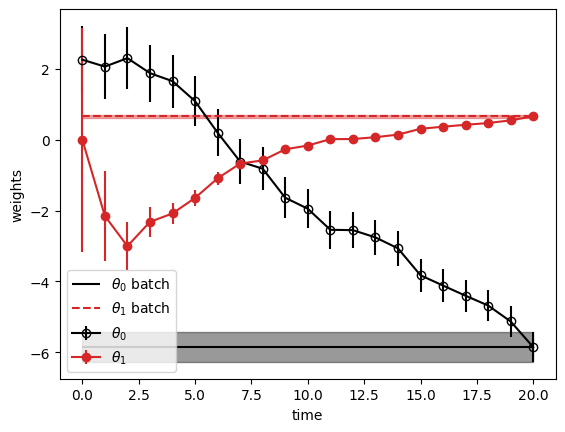

In [15]:
# Unpack kalman filter results
post_weights_kf, post_sigma_kf = kf_results
theta0_kf_hist, theta1_kf_hist = post_weights_kf.T
theta0_kf_err, theta1_kf_err = jnp.sqrt(post_sigma_kf[:, [0, 1], [0, 1]].T)

# Unpack batch results
post_weights_batch, post_prec_batch = batch_results
theta0_post_batch, theta1_post_batch = post_weights_batch
Sigma_post_batch = jnp.linalg.inv(post_prec_batch)
theta0_std_batch, theta1_std_batch = jnp.sqrt(Sigma_post_batch[[0, 1], [0, 1]])

fig, ax = plt.subplots()
timesteps = jnp.arange(len(theta0_kf_hist))

# Plot online kalman filter posterior.
ax.errorbar(timesteps, theta0_kf_hist, theta0_kf_err, fmt="-o", label=r"$\theta_0$", color="black", fillstyle="none")
ax.errorbar(timesteps, theta1_kf_hist, theta1_kf_err, fmt="-o", label=r"$\theta_1$", color="tab:red")

# Plot batch posterior.
ax.hlines(y=theta0_post_batch, xmin=timesteps[0], xmax=timesteps[-1], color="black", label=r"$\theta_0$ batch")
ax.hlines(
    y=theta1_post_batch, xmin=timesteps[0], xmax=timesteps[-1], color="tab:red", linestyle="--", label=r"$\theta_1$ batch"
)
ax.fill_between(timesteps, theta0_post_batch - theta0_std_batch, theta0_post_batch + theta0_std_batch, color="black", alpha=0.4)
ax.fill_between(timesteps, theta1_post_batch - theta1_std_batch, theta1_post_batch + theta1_std_batch, color="tab:red", alpha=0.4)

ax.set_xlabel("time")
ax.set_ylabel("weights")
ax.legend()